In [1]:
import glacierml as gl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2023-09-06 08:27:31.674371: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-06 08:27:31.719144: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 08:27:32.399597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = gl.coregister_data('4')
df = df.drop('RGIId', axis = 1)
# df = df.drop(['RGIId','CenLat','CenLon','Zmed','Zmax','Aspect'],axis = 1)
# df = df.drop(df[df['Thickness'] >= 300].index)
# df = df.drop(df[df['Thickness'] == 267].index)
# df = df.drop(df[df['Thickness'] == df['Thickness'].min()].index)

df = df.reset_index()
df = df.drop('index', axis = 1)
# create a copy of df to draw K test sets to be kept in a vault
df_sampler = df.copy()
df_trainer = df.copy()
rs = 0

df1test = df_sampler.sample(frac = 0.2,random_state = rs)
df_sampler = df_sampler.drop(df1test.index)

df2test = df_sampler.sample(frac = 0.25,random_state = rs)
df_sampler = df_sampler.drop(df2test.index)

df3test = df_sampler.sample(frac = 0.3333333,random_state = rs)
df_sampler = df_sampler.drop(df3test.index)

df4test = df_sampler.sample(frac = 0.5,random_state = rs)
df_sampler = df_sampler.drop(df4test.index)

df5test = df_sampler

df1 = df_trainer.drop(df1test.index)
df2 = df_trainer.drop(df2test.index)
df3 = df_trainer.drop(df3test.index)
df4 = df_trainer.drop(df4test.index)
df5 = df_trainer.drop(df5test.index)


2/2 [==============================] - 0s 2ms/step - loss: 27.8385


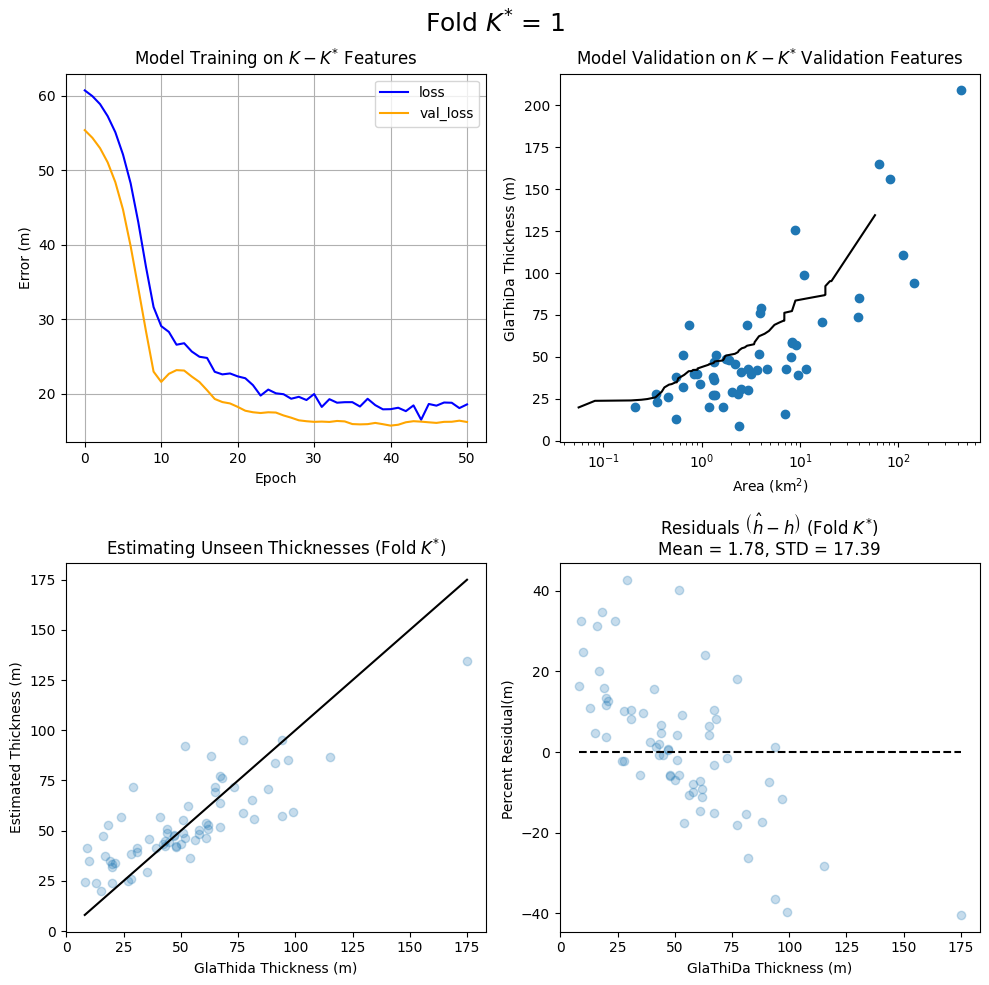

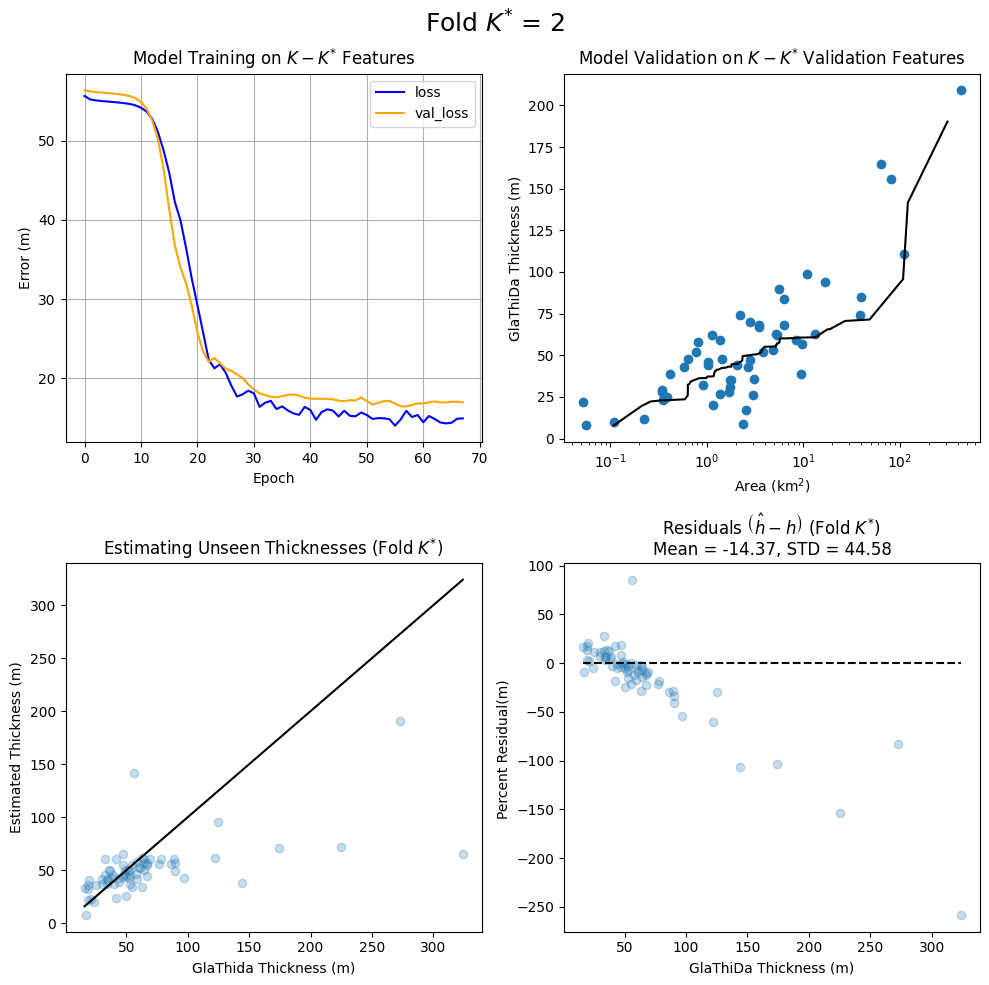

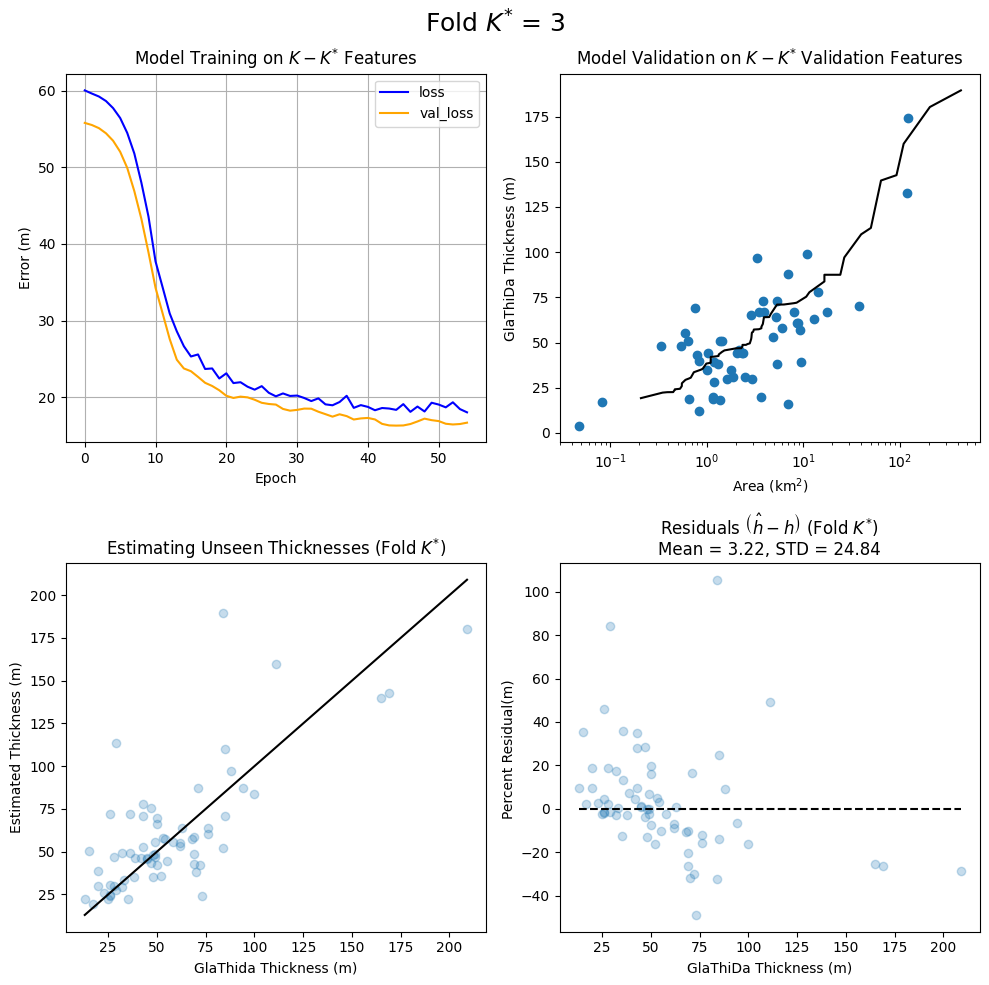

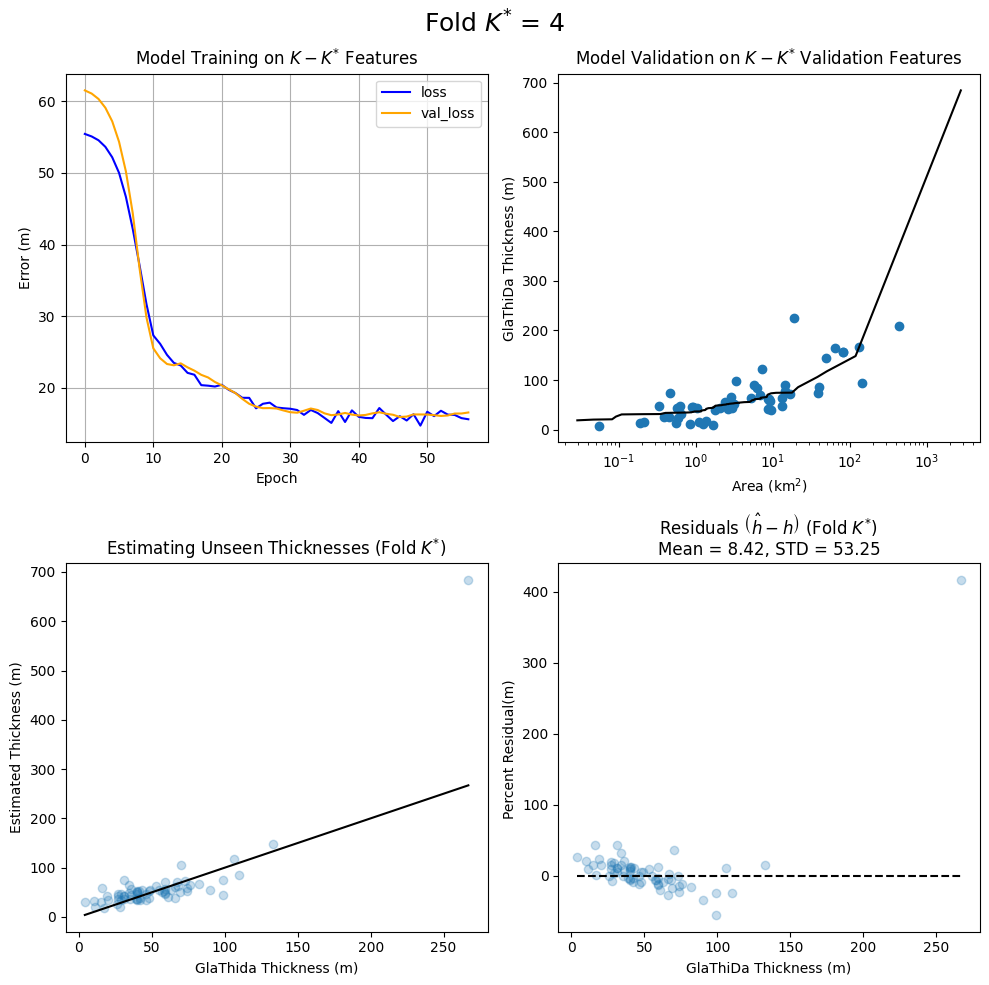

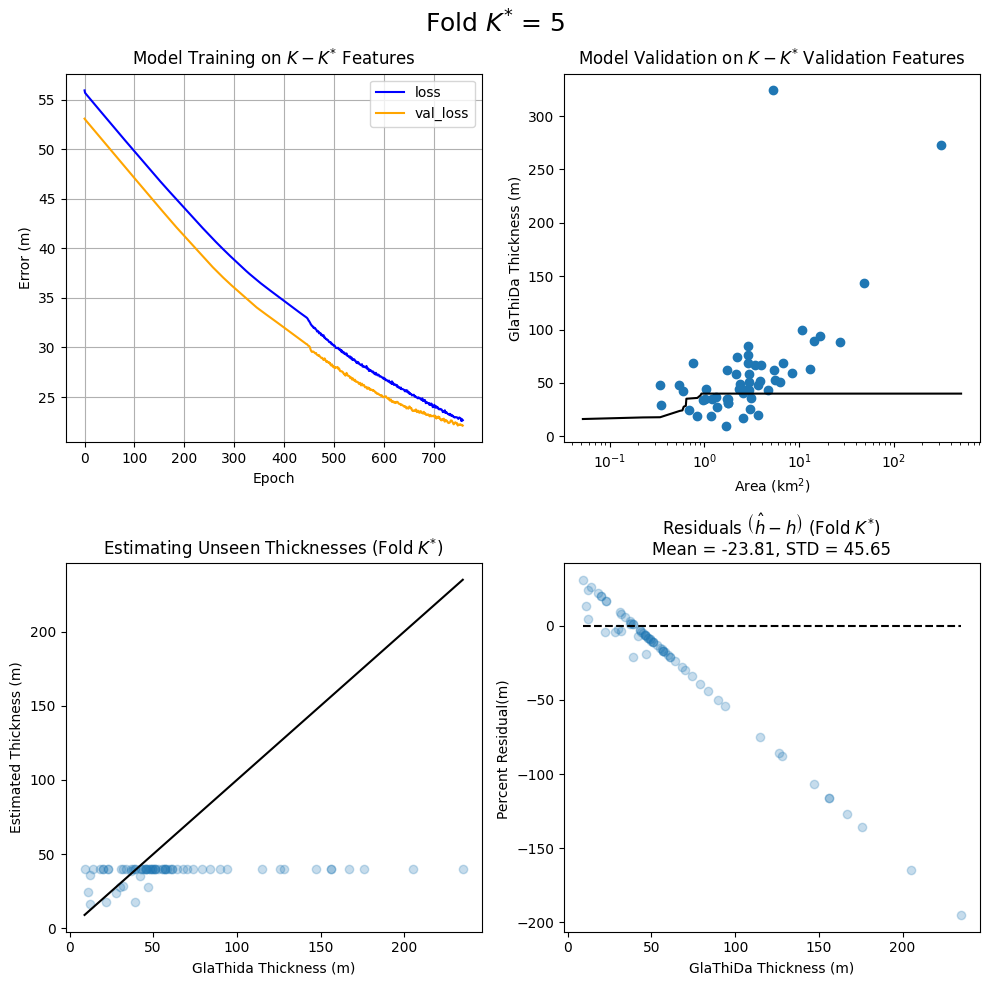

In [12]:
pr = 0.075
model = {}
model_history = {}
results = {}
normalizer = {}
y = {}
l1 = {}
l2 = {}
callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 10,
    verbose = 0,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True
)

df_list = [df1,df2,df3,df4,df5]
test_df_list = [df1test,df2test,df3test,df4test,df5test]
list = ['1','2','3','4','5']
# k = '1'

for k,dft,dftest in zip(list,df_list,test_df_list):
#     k = str(k)
#     fig, ax = plt.subplots(2,2,figsize = (10,10))

#     p = str(i)

    total_inputs = (len(df.columns)) * len(df)
    dp = pr * total_inputs
    tp = dp - (len(df.columns) + (len(df.columns)-1) )
    g = (len(df.columns) + (len(df.columns) - 1))
    l2[k] = 4
    l1[k] = int((dp - 1 - g - 2*l2[k]) / (10 + l2[k]))
    
    arch = str(l1[k]) + '-' + str(l2[k])

    train_features, test_features, train_labels, test_labels = gl.split_data(dft,0)
    normalizer[k] = preprocessing.Normalization(axis=-1)
    normalizer[k].adapt(np.array(train_features))

    model[k] = gl.build_dnn_model(
        normalizer[k], learning_rate = 0.01, layer_1 = l1[k], layer_2 = l2[k],
        loss = 'mae'
    )

    model_history[k] = model[k].fit(
        train_features,
        train_labels,
        validation_split=0.2,
        callbacks = [callback],
        verbose=0, 
        epochs=500
    )

    
    
    #     k = str(k)
    fig, ax = plt.subplots(2,2,figsize = (10,10))
    ax[0][0].plot(
        model_history[k].history['loss'], 
         label='loss',
        color = 'blue'
    )
    ax[0][0].plot(
        model_history[k].history['val_loss'], 
        label='val_loss',
        color = 'orange'
    )
    #   plt.ylim([0, 10])
    ax[0][0].set_xlabel('Epoch')
    ax[0][0].set_ylabel('Error (m)')
    ax[0][0].legend()
    ax[0][0].grid(True)
    ax[0][0].set_title('Model Training on $K-K^{*}$ Features')
    
    
    y[k] = model[k].predict(dftest.drop('Thickness',axis = 1)).flatten()
    ax[0][1].scatter(test_features['Area'],test_labels,label = 'Data')
#     ax[0][1].plot(
#         test_labels.sort_values(
#         ascending = True),test_labels.sort_values(
#         ascending = True),c = 'r',label = 'Data'
#     )
    ax[0][1].plot(
        dftest['Area'].sort_values(
        ascending = True),np.sort(y[k]),c = 'k',label = 'Predictions'
    )
    ax[0][1].set_xscale('log')
    ax[0][1].set_title('Model Validation on $K-K^{*}$ Validation Features')
    ax[0][1].set_xlabel('Area (km$^2$)')
    ax[0][1].set_ylabel('GlaThiDa Thickness (m)')
#     ax[0][1].legend()

    
    
    y[k] = model[k].predict(dftest.drop('Thickness',axis = 1)).flatten()    
    ax[1][1].scatter(
        dftest['Thickness'],y[k] - dftest['Thickness'],label = 'Data',alpha = 0.25
    )
    ax[1][1].plot(
        (dftest['Thickness'].min(),dftest['Thickness'].max()),
        (0,0),
        c = 'k',
        linestyle = '--'
    )
    mean = np.round((y[k] - dftest['Thickness']).mean(),2)
    std = np.round((y[k] - dftest['Thickness']).std(), 2)
#     ax[1][1].set_xscale('log')
    ax[1][1].set_title(
        r'Residuals $\left(\hat{h} - h\right)$ (Fold $K^{*}$) ' + '\n' +
        f'Mean = {mean}, STD = {std}'
    )
    ax[1][1].set_ylabel(r'Percent Residual(m) ')
    ax[1][1].set_xlabel('GlaThiDa Thickness (m)')
#     ax[0][1].legend()
#     plt.legend()
#     plt.show()
    
    
    
#     y = model[k].predict(dftest.drop('Thickness',axis = 1)).flatten()
    ax[1][0].scatter(dftest['Thickness'],y[k],label = 'Estimates', alpha = 0.25)
    ax[1][0].plot(
        (dftest['Thickness'].min(),dftest['Thickness'].max()),
        (dftest['Thickness'].min(),dftest['Thickness'].max()),
        'k'
    )
    ax[1][0].set_title('Estimating Unseen Thicknesses (Fold $K^{*}$)')
    ax[1][0].set_xlabel('GlaThida Thickness (m)')
    ax[1][0].set_ylabel('Estimated Thickness (m)')
#     ax[1][1]
    fig.suptitle('Fold $K^{*}$ = ' + k,fontsize = 18)
    plt.tight_layout()
    save_title = 'xval'+k
    plt.savefig(f'img/img_{save_title}.png', 
                transparent = False,  
                facecolor = 'white'
               )
#     ax[1][1].legend(loc = 'upper left')
#     ax[0][0] = gl.plot_loss(model_history[k].history)

#     plt.show()
    results[str(l1) + '-' + str(l2) + '_'+k] = model[k].evaluate(
        test_features, test_labels
    )
res = pd.DataFrame(results,index = ['Loss']).T
res = res.reset_index()

In [4]:
# df = gl.parameterize_data(p)
# df = df.drop(['RGIId'],axis = 1)
# k_y = (
#     k_model['5'].predict(df.drop('Thickness', axis = 1)).flatten() )
# res = k_y - df['Thickness']
# res.mean()

In [5]:
# x = df['Thickness']
# plt.scatter(
#     x,
#     k_y,alpha = 0.25
# )
# plt.plot(
#     (x.min(),x.max()),
#     (x.min(),x.max()),
#     c = 'k'
# )

In [6]:
# df = gl.parameterize_data('3')
# df = df.drop(['RGIId'],axis = 1)
# k_y = (
#     k_model['5'].predict(df.drop('Thickness', axis = 1)).flatten()+ 
#     k_model['4'].predict(df.drop('Thickness', axis = 1)).flatten()
# #     k_model['3'].predict(df.drop('Thickness', axis = 1)).flatten()
# ) / 2
# res = k_y - df['Thickness']
# res.mean()

In [7]:
# x = df['Thickness']
# plt.scatter(
#     x,
#     k_y,alpha = 0.25
# )
# plt.plot(
#     (x.min(),x.max()),
#     (x.min(),x.max()),
#     c = 'k'
# )


In [8]:

# frames = []
# for k in range(1,4,1):
#     save_path = 'xval'+str(k)
#     image = imageio.v2.imread(f'img/img_{save_path}.png')
#     frames.append(image)
# imageio.mimsave('xval_example.gif', # output gif
#                 frames,          # array of input frames
#                 duration = 8000,
#                 loop = 50
#                )   

In [9]:
# selected_k = res[res['Loss'] == res['Loss'].min()].index.str[-1].values.flatten()[0]
# selected_k = '1'

In [10]:
# predictions = pd.DataFrame()
# for k in k_list:
#     y = pd.Series(
#         model[k].predict(df.drop('Thickness',axis = 1)).flatten(),name = k
#     )
#     predictions = pd.concat([predictions, y], axis = 1)
# y_avg = predictions.mean(axis = 1)
# print(y_avg)
# x = df['Thickness']
# xy = np.vstack([np.log10(x),np.log10(y_avg)])
# z = gaussian_kde(xy)(xy)
# plt.scatter(x,y_avg,c =z,cmap = 'viridis',marker = '.')
# plt.plot(
#     (df['Thickness'].min(),df['Thickness'].max()),
#     (df['Thickness'].min(),df['Thickness'].max()),
#     c = 'orange'
# )
# plt.xlabel('GlaThiDa Thickness (m)')
# plt.ylabel('Estimated Thickness (m)')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

# plt.scatter(df['Thickness'],(y_avg - df['Thickness']) , alpha = 0.25)
# plt.plot(
#     (df['Thickness'].min(),df['Thickness'].max()),
#     (0,0),
#     c = 'k',
#     linestyle = '--'
# )
# plt.xlabel(('GlaThiDa Thickness (m)'))
# plt.ylabel('Residual (m)')
# mean = (y_avg - df['Thickness']).mean()
# print(f'Residual Mean = {mean}')

# std = (y_avg - df['Thickness']).std()
# print(f'Residual Standard Deviation = {std}')

In [11]:
# for i in range(3,6,1):
#     predictions = pd.DataFrame()
#     # for k in k_list:
#     y = pd.Series(
#         model[str(i)].predict(df.drop('Thickness',axis = 1)).flatten(),name = k
#     )
#     predictions = pd.concat([predictions, y], axis = 1)
#     predictions



#     y_avg = predictions.mean(axis = 1)
#     # print(y_avg)
#     # y_avg = y2.flatten()
#     x = df['Thickness']

#     xy = np.vstack([np.log10(x),np.log10(y_avg)])
#     z = gaussian_kde(xy)(xy)

#     plt.scatter(x,y_avg,c =z,cmap = 'viridis',marker = '.')
#     plt.plot(
#         (df['Thickness'].min(),df['Thickness'].max()),
#         (df['Thickness'].min(),df['Thickness'].max()),
#         c = 'orange'
#     )
#     plt.xlabel(('GlaThiDa Thickness (m)'))
#     plt.ylabel('Estimated Thickness (m)')

#     plt.xscale('log')
#     plt.yscale('log')
#     plt.show()

#     mean = (y_avg - df['Thickness']).mean()
#     print(f'Residual Mean = {mean}')

#     std = (y_avg - df['Thickness']).std()
#     print(f'Residual Standard Deviation = {std}')


#     plt.scatter(df['Thickness'],(y_avg - df['Thickness']) , alpha = 0.25)
#     plt.plot(
#         (df['Thickness'].min(),df['Thickness'].max()),
#         (0,0),
#         c = 'k',
#         linestyle = '--'
#     )
#     plt.xlabel(('GlaThiDa Thickness (m)'))
#     plt.ylabel('Residual (m)')
#     plt.show()
